In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import gensim
import matplotlib.pyplot as plt
import re
import pickle 
# Initializing the train model
from gensim.models import word2vec
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in reviews and listing data
reviews = pd.read_csv('reviews.csv')
listings = pd.read_csv('listings 2.csv')

In [3]:
len(reviews)

311277

In [6]:
# check null values in listings 
listings['review_scores_rating'].isnull().sum()

1421

In [7]:
# check null values in reviews 
reviews['comments'].isnull().sum()

79

In [8]:
# Drop null before covert float to integer(handle the null value issue before modeling, cause it will yell when converting nan to a different value format )
listings.dropna(subset=['review_scores_rating'], inplace = True)
reviews.dropna(subset=['comments'], inplace = True)


In [9]:
# convert scores to scale from 1 to 5
listings['review_scores_rating'] = listings['review_scores_rating'].astype(int)

In [10]:
# convert review scores to 1-5 scale, which would be imbalanced  
def convert_to_five_level(row):
    if row <= 60.0:
        return "1"
#     if row > 20.0 and row <= 40.0:
#         return 2
#     if row > 40.0 and row <= 60.0:
#         return 3
    if row > 60.0 and row <= 95.0:
        return "2"
    if row > 95.0 and row <= 100.0:
        return "3"
    return np.nan

In [11]:
listings['review_scores_rating_scaled'] = listings['review_scores_rating'].apply(lambda row: convert_to_five_level(row))

In [12]:
listings['review_scores_rating_scaled'].value_counts()

3    5481
2    187 
1    62  
Name: review_scores_rating_scaled, dtype: int64

#### From the histogram below, it indicates that the plot has severe imbalance issue, will adjust the imbalance problem in logistic regression

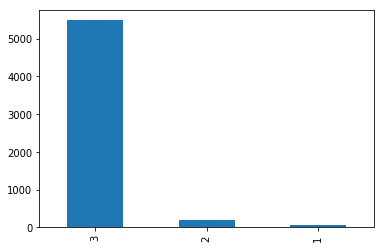

In [13]:
listings['review_scores_rating_scaled'].value_counts().plot(kind='bar')

(array([8.000e+00, 1.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 5.000e+01,
        3.500e+01, 1.810e+02, 5.590e+02, 4.887e+03]),
 array([ 20.,  28.,  36.,  44.,  52.,  60.,  68.,  76.,  84.,  92., 100.]),
 <a list of 10 Patch objects>)

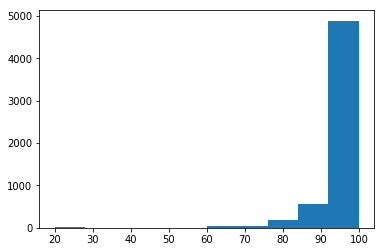

In [14]:
plt.hist(listings['review_scores_rating'])

In [21]:
df = reviews.merge(listings, left_on='listing_id', right_on='id')

In [30]:
len(df)

305913

In [24]:
# drop na
df.dropna(subset=['review_scores_rating'], inplace = True)

In [25]:
# drop duplicates, by colomn 'comments'
df.drop_duplicates(subset=['comments'], inplace = True)

In [28]:
# take only comments column
reviews_comments = df.iloc[:,5]

In [29]:
len(reviews_comments)

305913

In [75]:
with open('listing_reviews.pkl', 'wb') as f:
    pickle.dump(df, f)

### EDA

#### 1. Count how many hosts have returning guests (3332 hosts have returning guests, maximum returns per host is 29)

In [129]:
data_groups = df.groupby(['listing_id', 'reviewer_id','review_scores_rating_scaled'],as_index=False).agg({'date':'count'})

In [132]:
# df_test = data_groups[(data_groups['date'] > 1) & (data_groups['review_scores_rating_scaled'] != 5)]
df_test = data_groups[data_groups['date'] > 1]
df_test.sort_values(by=['date'], ascending=False)

In [115]:
df_tobe_removed = df_test['listing_id']

In [134]:
len(set(df_tobe_removed))

1527

Based on the analysis above, remove the listings that have more than 5 returning guests

In [123]:
df_listing_dropped = listings[~listings['id'].isin(df_tobe_removed)]

#### 2. Identify how many people only have one reivew (255088 out of 311198 (80%) reviewers wrote only one review)

In [94]:
data_count_review = df.groupby(['reviewer_id'],as_index=False).agg({'date':'count'})

In [96]:
data_count_review_test = data_count_review[data_count_review['date'] == 1]

In [97]:
len(data_count_review_test)

255088

#### 3. Find reviewers who write only 5 star reviews

In [ ]:
data_count_review = df.groupby(['reviewer_id',''],as_index=False).agg({'date':'count'})

In [19]:
def ProcessTextforSentiment(text):
    text_1 = [re.sub("[^a-zA-Z]"," ", review) for review in text]
    text_2 = [text.lower().split() for text in text_1]
    return text_2

In [20]:
review_text_split_lower = ProcessTextforSentiment(reviews_comments)

In [ ]:
bigram = gensim.models.Phrases(review_text_split_lower, min_count=10) # min_count ignore all words and bigrams with total collected count lower than this value. higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[review_text_split_lower], min_count=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

In [23]:
review_text_1 = [trigram_model[bigram_model[t]] for t in review_text_split_lower]

In [13]:
len(review_text_1)

305913

In [25]:
with open('review_text_1.pkl', 'wb') as f:
    pickle.dump(review_text_1, f)